In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
from qiskit import *
from qiskit.quantum_info import state_fidelity, DensityMatrix
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter, TomographyFitter
from qiskit.providers.ibmq.managed import IBMQJobManager

In [45]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [46]:
provider = IBMQ.get_provider(hub='ibm-q-hub-ntu', group='ntu-internal', project='default')

In [332]:
c_backend = provider.backends.ibmq_qasm_simulator
c_backend_local = Aer.get_backend('qasm_simulator')

In [5]:
def one_time_pad(qc, qbit, x):
    if x == 0:
        qc.i(qbit)
        
    elif x == 1:
        qc.x(qbit)
        
    elif x == 2:
        qc.y(qbit)
        
    elif x == 3:
        qc.z(qbit)
    
    else:
        print('The secret key is wrong !')
    
    return qc

In [6]:
def generate_circuit(initial_state, x, decryp):
    qr_a = QuantumRegister(2, 'alice')
    qr_b = QuantumRegister(1, 'bob')
#     cr = ClassicalRegister(1, 'result')
#     qc = QuantumCircuit(qr_a, qr_b, cr)
    qc = QuantumCircuit(qr_a, qr_b)
    qc.initialize(initial_state.data, qr_a[0])
    
    # encryption the state
    qc.barrier()
    
    one_time_pad(qc, qr_a[0], x)
    
    # teleportation 
    qc.barrier()
    qc.h(qr_a[1])
    qc.cx(qr_a[1], qr_b[0])
    
#     qc.barrier()
    qc.cx(qr_a[0], qr_a[1])
    qc.h(qr_a[0])
    
#     qc.barrier()
    qc.cz(qr_a[0], qr_b[0])
    qc.cx(qr_a[1], qr_b[0])
    
    qc.barrier()
    
    if decryp == True:
        one_time_pad(qc, qr_b[0], x)
    elif decryp == False:
        qc = qc
    else:
        print('The input is wrong !')
        del qc

#     qc.barrier()
#     qc.measure(qr_b, cr)
#     qc.draw(output = 'latex')
    return qc

In [175]:
# create blanck circuit to be used in for loop
qr_a = QuantumRegister(2, 'alice')
qr_b = QuantumRegister(1, 'bob')
# cr = ClassicalRegister(1, 'result')
qc = QuantumCircuit(qr_a, qr_b)

# identity density matrix
id_dmatrix = DensityMatrix(np.array([[1, 0], [0, 1]])/2)

# Teleport one random state via PQC

In [8]:
# create random state
init_state = qiskit.quantum_info.random_statevector(2, seed=None)
print('initial arbitrary state = ', init_state.data, '\n')
print('Density matrix of initial state is \n', DensityMatrix(init_state).data)

initial arbitrary state =  [0.47201039-0.67168176j 0.33042862-0.46568952j] 

Density matrix of initial state is 
 [[0.6739502+0.j         0.4687609-0.00213259j]
 [0.4687609+0.00213259j 0.3260498+0.j        ]]


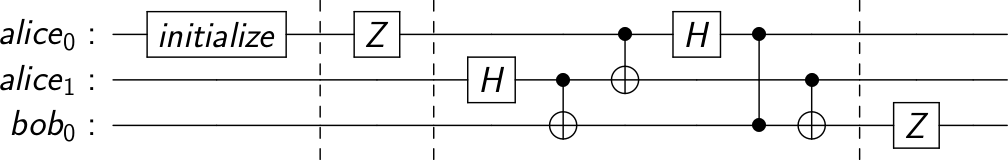

In [9]:
# create quantum circuit for teleport encryped state from Alice
# to Bob and decrype.
pqc_circuit = qc + generate_circuit(init_state, 3, True)

# generate latex code for quantum circuit
# print(pqc_circuit.draw(output='latex_source'))

# draw the quantum circuit
pqc_circuit.draw(output='latex', fold=1000)

In [10]:
# tomography the state bob received and decryped
qst_circuit= state_tomography_circuits(pqc_circuit, qr_b[0])
job = qiskit.execute(qst_circuit, c_backend_local, shots = 8192)

tomo = StateTomographyFitter(job.result(), qst_circuit)

rho = tomo.fit(method='cvx', verbose=False)
print('density matrix Bob decryped is \n', rho, '\n ')
print('Density matrix Alice prepared is \n', DensityMatrix(init_state).data, '\n')
print('The Fidelity between Bob\'s and Alice\'s state is =', state_fidelity(init_state, rho))

density matrix Bob decryped is 
 [[0.67114258+0.j         0.46630859-0.00402832j]
 [0.46630859+0.00402832j 0.32885742+0.j        ]] 
 
Density matrix Alice prepared is 
 [[0.6739502+0.j         0.4687609-0.00213259j]
 [0.4687609+0.00213259j 0.3260498+0.j        ]] 

The Fidelity between Bob's and Alice's state is = 0.9967322236492295


# Check the density matrix Eve got is $I_2$ on average

In [11]:
# create state Alice want to send
init_state = qiskit.quantum_info.random_statevector(2, seed=None)
print('initial state = ', init_state.data, '\n')
print('Density matrix of initial state is \n', DensityMatrix(init_state).data)

initial state =  [-0.00373931-0.80225079j  0.29499927-0.51899434j] 

Density matrix of initial state is 
 [[0.64362031+0.j         0.41526052-0.23860408j]
 [0.41526052+0.23860408j 0.35637969+0.j        ]]


In [12]:
# number of keys
key_size = 20

In [13]:
# create N random secret key to encrype the initial state
# to check that on average Eve got the identity density matrix
# key = np.random.randint(0, high=4, size=key_size, dtype=int)

In [14]:
# create circuit list that each in each 
# circuit Aclice's initial state is encrped by random key
circuit_list = []
for i in range(key_size):
    circuit_list.append(qc + generate_circuit(init_state, np.random.randint(0, high=4, size=1, dtype=int), False))

In [15]:
# tomography the states bob received
qst_circuit_list = []
rho_list = []
for i in range(key_size):
    qst_circuit= state_tomography_circuits(circuit_list[i], qr_b[0])
    for j in range(len(qst_circuit)):
        qst_circuit_list.append(qst_circuit[j])
#         qst_circuit_list[3*i+j].name= str(3*i+j)
#         print(qst_circuit_list[3*i+j].name)
job = qiskit.execute(qst_circuit_list, c_backend_local, shots = 8192)

In [18]:
result = job.result()
tomo = TomographyFitter(result, qst_circuit_list[0:3], meas_basis='Pauli', prep_basis='Pauli')
# print(tomo.data)
for i in range(len(circuit_list)-1):
    i = i+1
    result_temp = deepcopy(result)
    result_temp.results = result_temp.results[3*i:3*(i+1)]
    tomo.add_data(result_temp, qst_circuit_list[3*i:3*(i+1)])
#     print(tomo.data)
rho = tomo.fit(method='cvx', verbose=False)
# print(rho)

# # identity density matrix
id_dmatrix = DensityMatrix(np.array([[1, 0], [0, 1]])/2)
print('Average density matrix Eve hacked is \n', rho, '\n ')
print('Density matrix of identity is \n', id_dmatrix.data, '\n')
print('The Fidelity between Bob\'s and Alice\'s state is =', state_fidelity(rho, id_dmatrix.data))

Average density matrix Eve hacked is 
 [[0.54365234+0.j         0.04370117+0.04987183j]
 [0.04370117-0.04987183j 0.45634766+0.j        ]] 
 
Density matrix of identity is 
 [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]] 

The Fidelity between Bob's and Alice's state is = 0.993657250975072


# Fidelity of different times

## running on QASM Simulator (Simulating the QuantumCircuit by numerical method)

In [347]:
key_size_list = [5, 10, 20, 30, 40, 60, 100]
# key_size_list = [1, 2, 3, 4, 5]

circuit_list = []

for i in range(len(key_size_list)):
    key_size = key_size_list[i]
    for i in range(key_size):
        circuit_list.append(qc + generate_circuit(init_state, np.random.randint(0, high=4, size=1, dtype=int), False))

qst_circuit_list = []
for i in range(len(key_size_list)):
    for j in range(key_size_list[i]):
        qst_circuit = state_tomography_circuits(circuit_list[sum(key_size_list[0:i])+j], qr_b[0])
        for k in range(len(qst_circuit)):
            qst_circuit_list.append(qst_circuit[k])
#         print(len(qst_circuit_list))

# execute the circuits
job = qiskit.execute(qst_circuit_list, c_backend_local, shots = 8192)
print('Job ID is ', job.job_id())
result = job.result()

# if the number of circuits is large than the
# maximum value the backend provide, use this

# job_set = IBMQJobManager().run(qst_circuit_list, backend = c_backend_local, job_tags = ['PQC'], shots=8192)
# print('Job Set ID is ', job_set.job_set_id())
# job_set_result = job_set.results()
# result = job_set_result._get_result(0)[0]

rho_list = []
f_list = []

for i in range(len(key_size_list)):
    result_temp = deepcopy(result)
    result_temp.results = result_temp.results[3*sum(key_size_list[0:i]):3*sum(key_size_list[0:i])+3]
    tomo = TomographyFitter(result_temp, qst_circuit_list[3*sum(key_size_list[0:i]):3*sum(key_size_list[0:i])+3], meas_basis='Pauli', prep_basis='Pauli')
    print(tomo.data)
    for j in range(key_size_list[i]-1):
        result_temp = deepcopy(result)
        result_temp.results = result_temp.results[3*sum(key_size_list[0:i])+3*(j+1):3*sum(key_size_list[0:i])+3*(j+2)]
        tomo.add_data(result_temp, qst_circuit_list[3*sum(key_size_list[0:i])+3*(j+1):3*sum(key_size_list[0:i])+3*(j+2)])
        print(tomo.data)
#         print(result_temp.get_counts())
    rho = tomo.fit(method='cvx', verbose=False)
    print(rho)
    rho_list.append(rho)

    f_list.append(state_fidelity(rho, id_dmatrix.data))

Job ID is  7b2352d0-3102-4fc3-b47b-081f6d4be07f
{('X',): {'0': 678, '1': 7514}, ('Y',): {'0': 6052, '1': 2140}, ('Z',): {'0': 2939, '1': 5253}}
{('X',): {'0': 8151, '1': 8233}, ('Y',): {'0': 12152, '1': 4232}, ('Z',): {'0': 8198, '1': 8186}}
{('X',): {'0': 15662, '1': 8914}, ('Y',): {'0': 18230, '1': 6346}, ('Z',): {'0': 13492, '1': 11084}}
{('X',): {'0': 16359, '1': 16409}, ('Y',): {'0': 24331, '1': 8437}, ('Z',): {'0': 16456, '1': 16312}}
{('X',): {'0': 23888, '1': 17072}, ('Y',): {'0': 30431, '1': 10529}, ('Z',): {'0': 21811, '1': 19149}}
[[0.53249512+0.j         0.08320313-0.24294434j]
 [0.08320313+0.24294434j 0.46750488+0.j        ]]
{('X',): {'0': 699, '1': 7493}, ('Y',): {'0': 6021, '1': 2171}, ('Z',): {'0': 2872, '1': 5320}}
{('X',): {'0': 8160, '1': 8224}, ('Y',): {'0': 12013, '1': 4371}, ('Z',): {'0': 8186, '1': 8198}}
{('X',): {'0': 15665, '1': 8911}, ('Y',): {'0': 18104, '1': 6472}, ('Z',): {'0': 13426, '1': 11150}}
{('X',): {'0': 16365, '1': 16403}, ('Y',): {'0': 20222, '1

{('X',): {'0': 70262, '1': 36234}, ('Y',): {'0': 51277, '1': 55219}, ('Z',): {'0': 47554, '1': 58942}}
{('X',): {'0': 77749, '1': 36939}, ('Y',): {'0': 57371, '1': 57317}, ('Z',): {'0': 52841, '1': 61847}}
{('X',): {'0': 78456, '1': 44424}, ('Y',): {'0': 63417, '1': 59463}, ('Z',): {'0': 55750, '1': 67130}}
{('X',): {'0': 79157, '1': 51915}, ('Y',): {'0': 65619, '1': 65453}, ('Z',): {'0': 60987, '1': 70085}}
{('X',): {'0': 86675, '1': 52589}, ('Y',): {'0': 71727, '1': 67537}, ('Z',): {'0': 66239, '1': 73025}}
{('X',): {'0': 87347, '1': 60109}, ('Y',): {'0': 77759, '1': 69697}, ('Z',): {'0': 69147, '1': 78309}}
{('X',): {'0': 88077, '1': 67571}, ('Y',): {'0': 83826, '1': 71822}, ('Z',): {'0': 72028, '1': 83620}}
{('X',): {'0': 88831, '1': 75009}, ('Y',): {'0': 89876, '1': 73964}, ('Z',): {'0': 74980, '1': 88860}}
{('X',): {'0': 96317, '1': 75715}, ('Y',): {'0': 95919, '1': 76113}, ('Z',): {'0': 80285, '1': 91747}}
{('X',): {'0': 103772, '1': 76452}, ('Y',): {'0': 98074, '1': 82150}, ('Z

{('X',): {'0': 170781, '1': 238819}, ('Y',): {'0': 189520, '1': 220080}, ('Z',): {'0': 214599, '1': 195001}}
{('X',): {'0': 171467, '1': 246325}, ('Y',): {'0': 195607, '1': 222185}, ('Z',): {'0': 217545, '1': 200247}}
{('X',): {'0': 178962, '1': 247022}, ('Y',): {'0': 201640, '1': 224344}, ('Z',): {'0': 222779, '1': 203205}}
{('X',): {'0': 186406, '1': 247770}, ('Y',): {'0': 203791, '1': 230385}, ('Z',): {'0': 225760, '1': 208416}}
{('X',): {'0': 187085, '1': 255283}, ('Y',): {'0': 205938, '1': 236430}, ('Z',): {'0': 231097, '1': 211271}}
{('X',): {'0': 187794, '1': 262766}, ('Y',): {'0': 208061, '1': 242499}, ('Z',): {'0': 236406, '1': 214154}}
{('X',): {'0': 188492, '1': 270260}, ('Y',): {'0': 210196, '1': 248556}, ('Z',): {'0': 241736, '1': 217016}}
{('X',): {'0': 195969, '1': 270975}, ('Y',): {'0': 216277, '1': 250667}, ('Z',): {'0': 247018, '1': 219926}}
{('X',): {'0': 203506, '1': 271630}, ('Y',): {'0': 222322, '1': 252814}, ('Z',): {'0': 252285, '1': 222851}}
{('X',): {'0': 2041

{('X',): {'0': 250855, '1': 298009}, ('Y',): {'0': 284720, '1': 264144}, ('Z',): {'0': 259320, '1': 289544}}
{('X',): {'0': 251517, '1': 305539}, ('Y',): {'0': 286824, '1': 270232}, ('Z',): {'0': 264647, '1': 292409}}
{('X',): {'0': 252204, '1': 313044}, ('Y',): {'0': 292872, '1': 272376}, ('Z',): {'0': 267611, '1': 297637}}
{('X',): {'0': 252916, '1': 320524}, ('Y',): {'0': 295075, '1': 278365}, ('Z',): {'0': 272729, '1': 300711}}
{('X',): {'0': 260414, '1': 321218}, ('Y',): {'0': 297152, '1': 284480}, ('Z',): {'0': 275682, '1': 305950}}
{('X',): {'0': 261106, '1': 328718}, ('Y',): {'0': 303180, '1': 286644}, ('Z',): {'0': 278654, '1': 311170}}
{('X',): {'0': 268568, '1': 329448}, ('Y',): {'0': 305292, '1': 292724}, ('Z',): {'0': 281589, '1': 316427}}
{('X',): {'0': 269228, '1': 336980}, ('Y',): {'0': 311334, '1': 294874}, ('Z',): {'0': 284433, '1': 321775}}
{('X',): {'0': 276745, '1': 337655}, ('Y',): {'0': 317359, '1': 297041}, ('Z',): {'0': 289671, '1': 324729}}
{('X',): {'0': 2774

Unexpected exception in keepalive ping task
Traceback (most recent call last):
  File "/home/pyserver/miniconda3/lib/python3.8/site-packages/websockets/protocol.py", line 984, in keepalive_ping
    ping_waiter = yield from self.ping()
  File "/home/pyserver/miniconda3/lib/python3.8/site-packages/websockets/protocol.py", line 583, in ping
    yield from self.ensure_open()
  File "/home/pyserver/miniconda3/lib/python3.8/site-packages/websockets/protocol.py", line 656, in ensure_open
    raise ConnectionClosed(
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


In [363]:
import csv
with open('20200625-1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(key_size_list)
    writer.writerow(f_list)

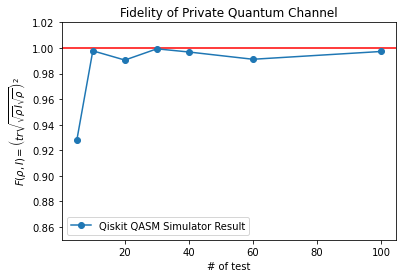

In [382]:
plt.figure(facecolor='w')
plt.title('Fidelity of Private Quantum Channel')
plt.axhline(1, color= 'r')
plt.plot(key_size_list, f_list, '-o', label='Qiskit QASM Simulator Result')
plt.legend(loc='lower left')
plt.xlabel('# of test')
plt.ylabel(r'$F(\rho, I)={\left(tr \sqrt{\sqrt{\rho} I \sqrt{\rho}} \right)}^2$')
plt.ylim(0.85, 1.02)
plt.savefig('20200625-1.pdf', bbox_inches = 'tight', transparent = True)
plt.show()

## running on IBMQ Real Device

In [448]:
# choose the real device backend to run the circuits
# qiskit.providers.ibmq.least_busy(provider.backends())

In [447]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-hub-ntu', group='ntu-internal', project='default')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-hub-ntu', group='ntu-internal', project='default')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-hub-ntu', group='ntu-internal', project='default')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q-hub-ntu', group='ntu-internal', project='default')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q-hub-ntu', group='ntu-internal', project='default')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q-hub-ntu', group='ntu-internal', project='default')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q-hub-ntu', group='ntu-internal', project='default')>,
 <IBMQBackend('ibmq_almaden') from IBMQ(hub='ibm-q-hub-ntu', group='ntu-internal', project='default')>,
 <IBMQBackend('ibmq_rochester') from IBMQ(hub='ibm-q-hub-ntu', group='ntu-internal', project='default')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q-hub-nt

In [454]:
q_backend = provider.backends.ibmq_almaden

In [461]:
initial_layout=[4, 3, 2]

In [462]:
key_size_list = [5, 10, 20, 30, 40, 60, 100]
# key_size_list = [1, 2, 3, 4, 5]

circuit_list = []

for i in range(len(key_size_list)):
    key_size = key_size_list[i]
    for i in range(key_size):
        circuit_list.append(qc + generate_circuit(init_state, np.random.randint(0, high=4, size=1, dtype=int), False))

qst_circuit_list = []
for i in range(len(key_size_list)):
    for j in range(key_size_list[i]):
        qst_circuit = state_tomography_circuits(circuit_list[sum(key_size_list[0:i])+j], qr_b[0])
        for k in range(len(qst_circuit)):
            qst_circuit_list.append(qst_circuit[k])
#         print(len(qst_circuit_list))

# execute the circuits
job = qiskit.execute(qst_circuit_list, q_backend, shots = 8192, optimization_level = 0, initial_layout = initial_layout)
print('Job ID is ', job.job_id())
result = job.result()
# result = q_backend.retrieve_job('5ef3c9ba74e2c3001237d67b')

# if the number of circuits is large than the
# maximum value the backend provide, use this

# job_set = IBMQJobManager().run(qst_circuit_list, backend = c_backend_local, job_tags = ['PQC']
#                                , shots=8192, optimization_level = 0, initial_layout = initial_layout)
# print('Job Set ID is ', job_set.job_set_id())
# job_set_result = job_set.results()
# result = job_set_result._get_result(0)[0]

rho_list = []
f_list = []

for i in range(len(key_size_list)):
    result_temp = deepcopy(result)
    result_temp.results = result_temp.results[3*sum(key_size_list[0:i]):3*sum(key_size_list[0:i])+3]
    tomo = TomographyFitter(result_temp, qst_circuit_list[3*sum(key_size_list[0:i]):3*sum(key_size_list[0:i])+3], meas_basis='Pauli', prep_basis='Pauli')
    print(tomo.data)
    for j in range(key_size_list[i]-1):
        result_temp = deepcopy(result)
        result_temp.results = result_temp.results[3*sum(key_size_list[0:i])+3*(j+1):3*sum(key_size_list[0:i])+3*(j+2)]
        tomo.add_data(result_temp, qst_circuit_list[3*sum(key_size_list[0:i])+3*(j+1):3*sum(key_size_list[0:i])+3*(j+2)])
        print(tomo.data)
#         print(result_temp.get_counts())
    rho = tomo.fit(method='cvx', verbose=False)
    print(rho)
    rho_list.append(rho)

    f_list.append(state_fidelity(rho, id_dmatrix.data))

Job ID is  5ef3c9ba74e2c3001237d67b
{('X',): {'0': 5854, '1': 2338}, ('Y',): {'0': 5255, '1': 2937}, ('Z',): {'0': 4300, '1': 3892}}
{('X',): {'0': 9889, '1': 6495}, ('Y',): {'0': 10039, '1': 6345}, ('Z',): {'0': 9460, '1': 6924}}
{('X',): {'0': 16091, '1': 8485}, ('Y',): {'0': 13721, '1': 10855}, ('Z',): {'0': 13784, '1': 10792}}
{('X',): {'0': 18903, '1': 13865}, ('Y',): {'0': 17276, '1': 15492}, ('Z',): {'0': 17206, '1': 15562}}
{('X',): {'0': 23812, '1': 17148}, ('Y',): {'0': 21362, '1': 19598}, ('Z',): {'0': 22305, '1': 18655}}
[[0.54455566+0.j        0.08134766-0.0215332j]
 [0.08134766+0.0215332j 0.45544434+0.j       ]]
{('X',): {'0': 3843, '1': 4349}, ('Y',): {'0': 5127, '1': 3065}, ('Z',): {'0': 3813, '1': 4379}}
{('X',): {'0': 9087, '1': 7297}, ('Y',): {'0': 9588, '1': 6796}, ('Z',): {'0': 8129, '1': 8255}}
{('X',): {'0': 13648, '1': 10928}, ('Y',): {'0': 12127, '1': 12449}, ('Z',): {'0': 12439, '1': 12137}}
{('X',): {'0': 19329, '1': 13439}, ('Y',): {'0': 17805, '1': 14963}, 

{('X',): {'0': 51287, '1': 47017}, ('Y',): {'0': 50067, '1': 48237}, ('Z',): {'0': 50758, '1': 47546}}
{('X',): {'0': 57371, '1': 49125}, ('Y',): {'0': 53800, '1': 52696}, ('Z',): {'0': 55757, '1': 50739}}
{('X',): {'0': 59270, '1': 55418}, ('Y',): {'0': 57887, '1': 56801}, ('Z',): {'0': 59102, '1': 55586}}
{('X',): {'0': 66134, '1': 56746}, ('Y',): {'0': 62325, '1': 60555}, ('Z',): {'0': 62908, '1': 59972}}
{('X',): {'0': 72947, '1': 58125}, ('Y',): {'0': 66854, '1': 64218}, ('Z',): {'0': 66774, '1': 64298}}
{('X',): {'0': 75433, '1': 63831}, ('Y',): {'0': 70888, '1': 68376}, ('Z',): {'0': 70289, '1': 68975}}
{('X',): {'0': 77341, '1': 70115}, ('Y',): {'0': 74897, '1': 72559}, ('Z',): {'0': 73717, '1': 73739}}
{('X',): {'0': 84223, '1': 71425}, ('Y',): {'0': 79461, '1': 76187}, ('Z',): {'0': 77709, '1': 77939}}
{('X',): {'0': 90342, '1': 73498}, ('Y',): {'0': 82352, '1': 81488}, ('Z',): {'0': 82734, '1': 81106}}
{('X',): {'0': 97258, '1': 74774}, ('Y',): {'0': 86860, '1': 85172}, ('Z'

{('X',): {'0': 232882, '1': 168526}, ('Y',): {'0': 211814, '1': 189594}, ('Z',): {'0': 208688, '1': 192720}}
{('X',): {'0': 236604, '1': 172996}, ('Y',): {'0': 216740, '1': 192860}, ('Z',): {'0': 212455, '1': 197145}}
{('X',): {'0': 242081, '1': 175711}, ('Y',): {'0': 220850, '1': 196942}, ('Z',): {'0': 217631, '1': 200161}}
{('X',): {'0': 245120, '1': 180864}, ('Y',): {'0': 223073, '1': 202911}, ('Z',): {'0': 221641, '1': 204343}}
{('X',): {'0': 248351, '1': 185825}, ('Y',): {'0': 226621, '1': 207555}, ('Z',): {'0': 225882, '1': 208294}}
{('X',): {'0': 253322, '1': 189046}, ('Y',): {'0': 230590, '1': 211778}, ('Z',): {'0': 230119, '1': 212249}}
{('X',): {'0': 258293, '1': 192267}, ('Y',): {'0': 234643, '1': 215917}, ('Z',): {'0': 234070, '1': 216490}}
{('X',): {'0': 260733, '1': 198019}, ('Y',): {'0': 238713, '1': 220039}, ('Z',): {'0': 237510, '1': 221242}}
{('X',): {'0': 264728, '1': 202216}, ('Y',): {'0': 241687, '1': 225257}, ('Z',): {'0': 241578, '1': 225366}}
{('X',): {'0': 2670

{('X',): {'0': 304055, '1': 236617}, ('Y',): {'0': 283170, '1': 257502}, ('Z',): {'0': 287492, '1': 253180}}
{('X',): {'0': 307959, '1': 240905}, ('Y',): {'0': 287339, '1': 261525}, ('Z',): {'0': 291555, '1': 257309}}
{('X',): {'0': 311008, '1': 246048}, ('Y',): {'0': 290880, '1': 266176}, ('Z',): {'0': 296924, '1': 260132}}
{('X',): {'0': 313337, '1': 251911}, ('Y',): {'0': 294988, '1': 270260}, ('Z',): {'0': 300630, '1': 264618}}
{('X',): {'0': 316308, '1': 257132}, ('Y',): {'0': 297931, '1': 275509}, ('Z',): {'0': 305587, '1': 267853}}
{('X',): {'0': 320963, '1': 260669}, ('Y',): {'0': 300824, '1': 280808}, ('Z',): {'0': 310723, '1': 270909}}
{('X',): {'0': 323996, '1': 265828}, ('Y',): {'0': 304480, '1': 285344}, ('Z',): {'0': 315718, '1': 274106}}
{('X',): {'0': 326999, '1': 271017}, ('Y',): {'0': 307356, '1': 290660}, ('Z',): {'0': 320797, '1': 277219}}
{('X',): {'0': 329434, '1': 276774}, ('Y',): {'0': 312299, '1': 293909}, ('Z',): {'0': 324258, '1': 281950}}
{('X',): {'0': 3334

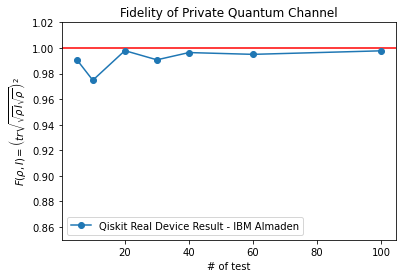

In [466]:
plt.figure(facecolor='w')
plt.title('Fidelity of Private Quantum Channel')
plt.axhline(1, color= 'r')
plt.plot(key_size_list, f_list, '-o', label='Qiskit Real Device Result - IBM Almaden')
plt.legend(loc='lower left')
plt.xlabel('# of test')
plt.ylabel(r'$F(\rho, I)={\left(tr \sqrt{\sqrt{\rho} I \sqrt{\rho}} \right)}^2$')
plt.ylim(0.85, 1.02)
plt.savefig('20200625-2.pdf', bbox_inches = 'tight', transparent = True)
plt.show()